# Blind Source Separation



In this notebook, the task would to be to separate the independant images (sources) from the mixed images (observations). The observations are generated by mixing the sources with a random coefficients matrix. 

For this puspose, the images sources would be generated using the MNIST dataset and the fashion MNIST dataset. The observations would be generated by mixing the sources with a random coefficients matrix.


The image below will show a schema of the problem in the case of audio signals. The same problem can be applied to images.


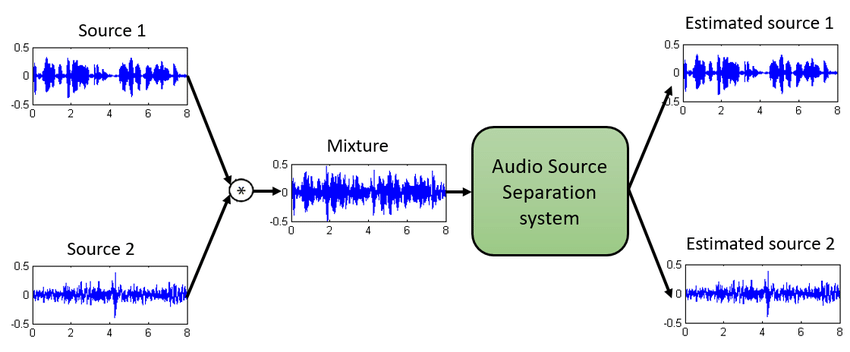

# Imporing Libraries

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2


# Import MNIST data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import tqdm.notebook as tqdm



# Preprocessing

For the preprocessing, lets denote $S_1$ the set of images from the MNIST dataset and $S_2$ the set of images from the fashion MNIST dataset. The sources would be generated by reshaping the images to a vector of size $32 \times 32$.


The set of mixed observations would be a set of Images $M$ of images $m_i$ such that $m_i = \alpha s_1 + \beta s_2$ where $\alpha$ and $\beta$ are random coefficients between 0 and 1 and $\alpha + \beta = 1$.



## Importing Datasets

In [2]:
# Fixing import parameters
SIZE_IMG = 32
BATCH_SIZE = 128
MNIST_MIX_PERCENTAGE= 0.5


Let's import the Mnist and Fashion Mnist datasets from the pytorch library.

In [3]:
transform_mnist = transforms.Compose([
    # Resize to 32x32
    transforms.Resize((SIZE_IMG, SIZE_IMG)),
    transforms.Grayscale(num_output_channels=1),
        # To tensor
    transforms.ToTensor(),
])

transform_fashion = transforms.Compose([
    # Resize to 32x32
    transforms.Resize((SIZE_IMG, SIZE_IMG)),
    transforms.Grayscale(num_output_channels=1),
    # To tensor
    transforms.ToTensor(),
])

Mnist_Train, Mnist_Test  = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist), datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

Fashion_Train, Fashion_Test = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_fashion), datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_fashion)



In [4]:
print("Number of samples in Mnist_Train:", len(Mnist_Train))
print("Number of samples in Mnist_Test:", len(Mnist_Test))
print("Number of samples in Fashion_Train:", len(Fashion_Train))
print("Number of samples in Fashion_Test:", len(Fashion_Test))

Number of samples in Mnist_Train: 60000
Number of samples in Mnist_Test: 10000
Number of samples in Fashion_Train: 60000
Number of samples in Fashion_Test: 10000


## Mixing the sources

In [5]:
def Create_Minst_Fashion_Dataset(Mnist_Data, Fashion_Data,Mnist_Size,Fashion_Size, percentage = 0.5):

    class CustomDataset(Dataset):
        def __init__(self, Mnist, Fashion, percentage):
            self.Mnist = Mnist
            self.Fashion = Fashion
            self.Mnist_len = len(Mnist)
            self.Fashion_len = len(Fashion)
            self.percentage = percentage
        def __len__(self):
            return self.Mnist_len * self.Fashion_len

        def __getitem__(self, idx):
            img_mnist, _ = self.Mnist[idx % self.Mnist_len]
            img_fashion, _ = self.Fashion[idx % self.Fashion_len]

            X = img_mnist * self.percentage + img_fashion * (1 - self.percentage)
            Y = torch.stack([img_mnist, img_fashion], dim=0)
            return X, Y
        
    return CustomDataset(Mnist_Data, Fashion_Data, percentage)


Here we will create train and test dataloaders for the mixed images. Data loaders are used to load the data in batches and shuffle the data.

In [6]:
train_dataset = Create_Minst_Fashion_Dataset(Mnist_Train, Fashion_Train, 10000, 10000, MNIST_MIX_PERCENTAGE)
test_dataset = Create_Minst_Fashion_Dataset(Mnist_Test, Fashion_Test, 1000, 1000, MNIST_MIX_PERCENTAGE)


SIZE_TRAIN = 70000
SIZE_TEST = 70000

#Take only 30000 first samples
train_dataset = torch.utils.data.Subset(train_dataset, range(SIZE_TRAIN))
test_dataset = torch.utils.data.Subset(test_dataset, range(SIZE_TEST))


# Create data loaders for training and testing data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=True)





## Visualizing the data

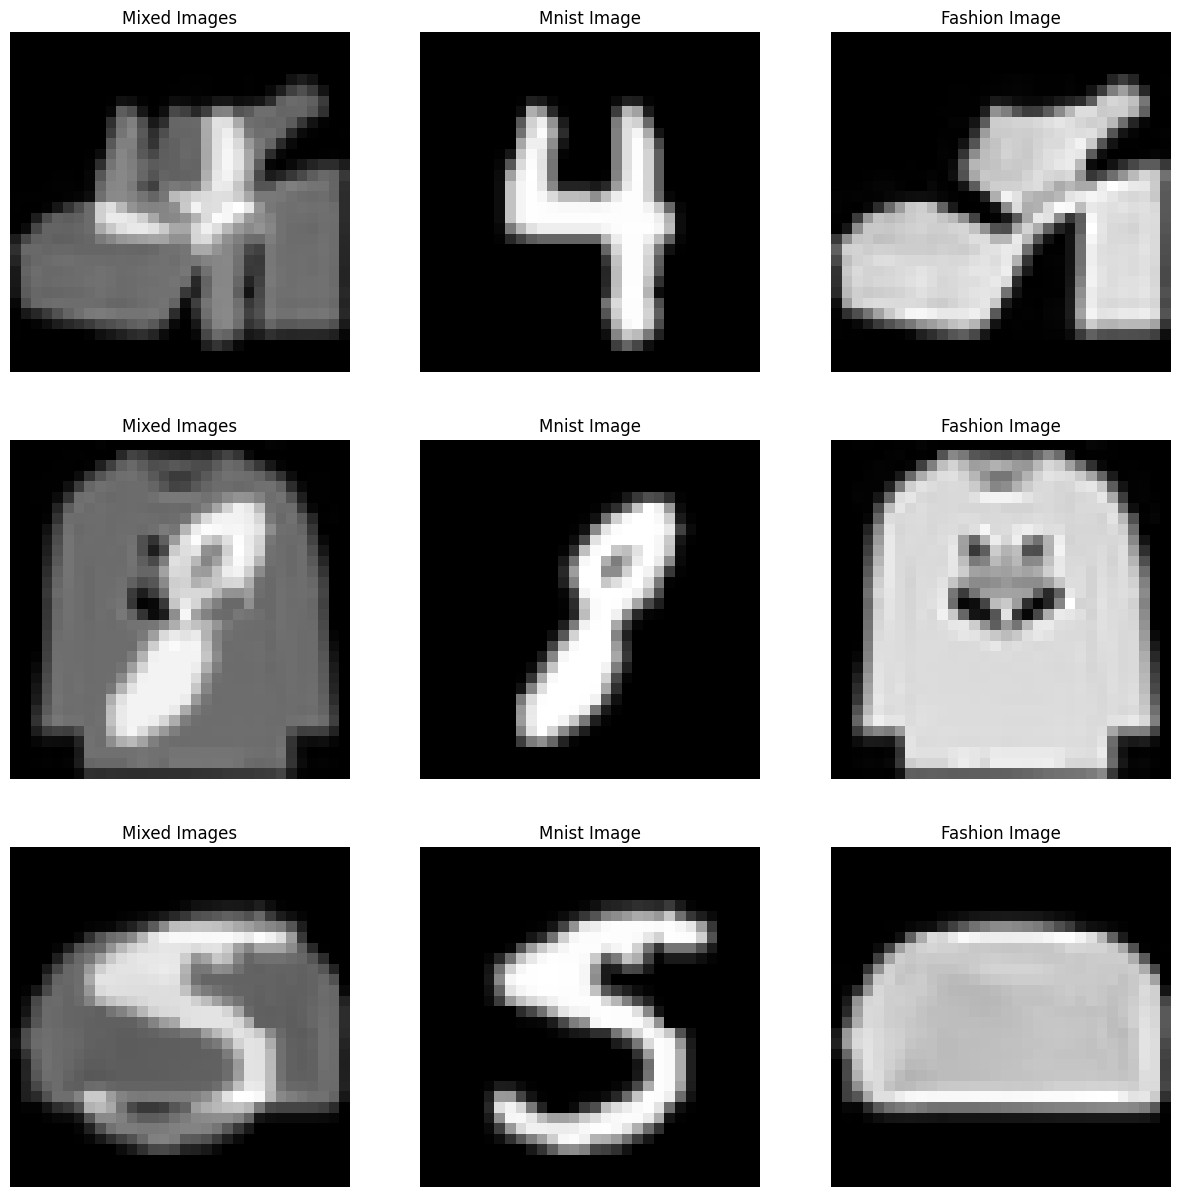

In [7]:
def Show_Images(train_dataset, n = 3):
    fig, ax = plt.subplots(n, 3, figsize=(15, n*5))

    Idx = np.random.randint(0, len(train_dataset), n)

    for i, idx in enumerate(Idx):
        X, Y = train_dataset[idx]
        ax[i, 0].imshow(X.squeeze(), cmap='gray')
        ax[i, 0].set_title('Mixed Images')
        ax[i, 0].axis('off')

        for j in range(2):
            ax[i, j+1].imshow(Y[j].squeeze(), cmap='gray')
            if j == 0:
                ax[i, j+1].set_title('Mnist Image')
            else:
                ax[i, j+1].set_title('Fashion Image')
            ax[i, j+1].axis('off')

    plt.show()


Show_Images(train_dataset)




# Training the model

In order to perform the tast, we will use a very specific Neural Network architechtur. We will specifically use the U-Net architecture. The U-Net architecture is a convolutional neural network that was developed for biomedical image segmentation. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations.




The Unet is composed of an encoder and a decoder. The encoder is a typical convolutional neural network that reduces the spatial dimensions of the input image. The decoder network is used to increase the spatial dimensions of the encoded image. The encoder and decoder are connected through skip connections. The skip connections are used to concatenate the output of the encoder to the input of the decoder. This helps in preserving the spatial information of the image.


The U-Net architecture is composed of the following layers 

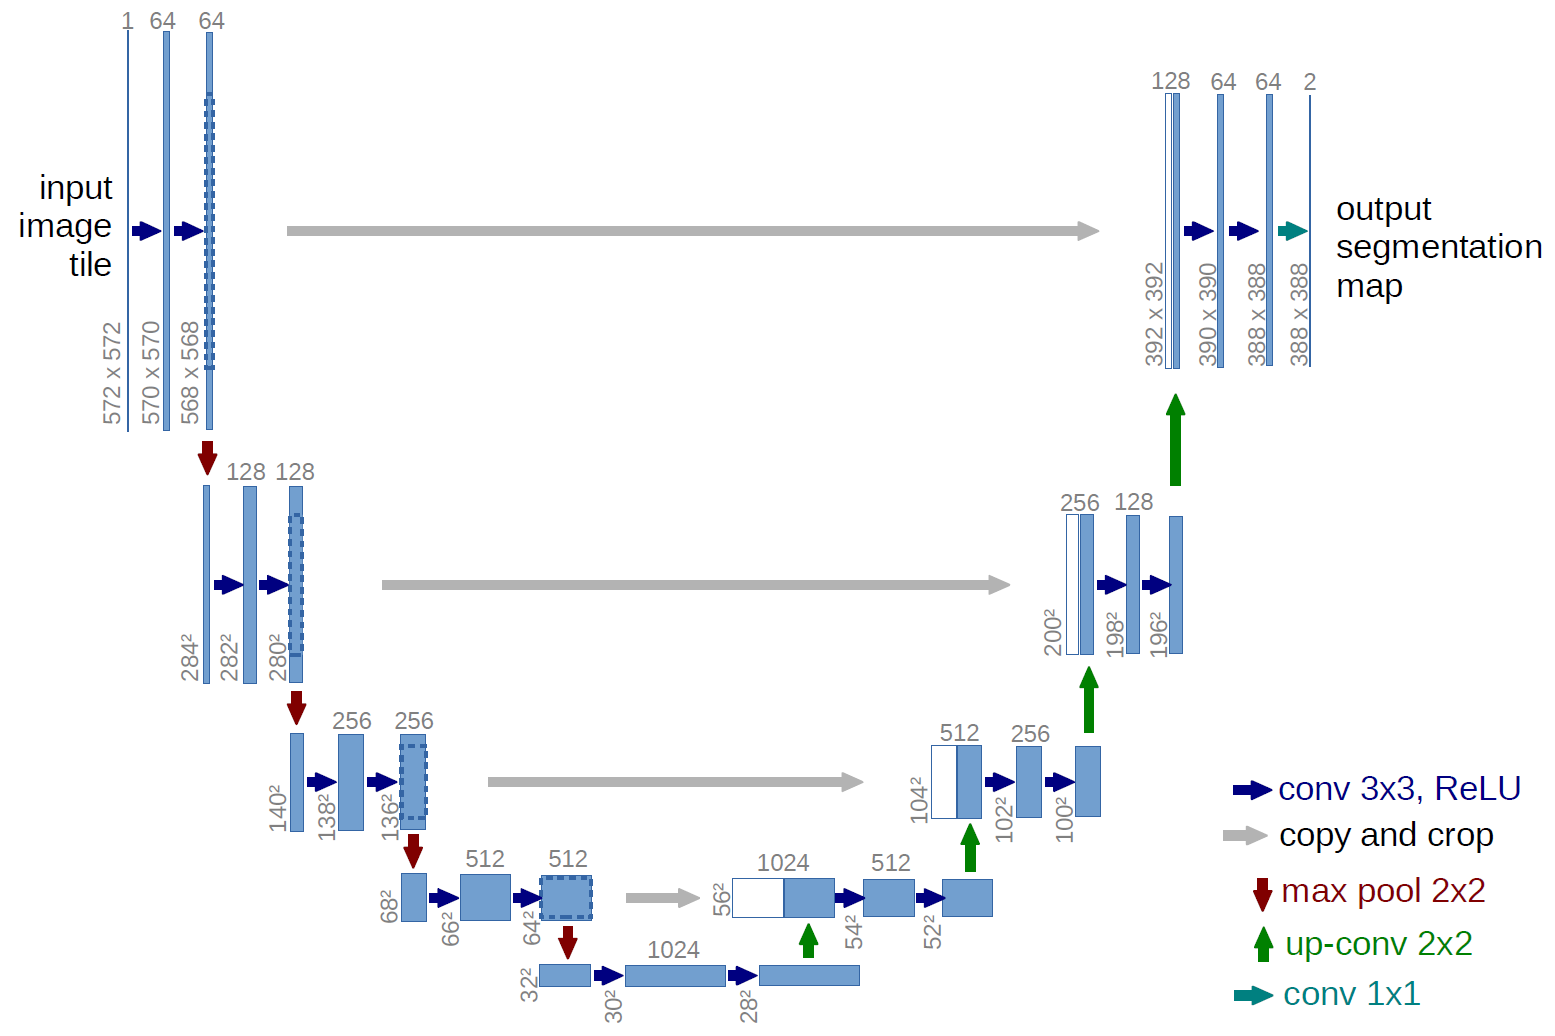

> We should note that the U-Net architechture shown in the picture contains some errors. Indeed, the number of channels in the last layer of any level in the decoder must half the number of channels in the preceding layer in the same level of the decoder.

> In order to train the model, we will use the Mean Squared Error loss function and the Adam optimizer. The model will be trained for 10 epochs.

The mean squared error loss function is defined as follows:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

where $y_i$ is the true value and $\hat{y}_i$ is the predicted value.


## Mnist Model

In [8]:
class DoubleConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, Residual=False):
        if not mid_channels:
            mid_channels = out_channels

        self.Residual = Residual

        super(DoubleConv2D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),  # convolutional layer 1
            nn.BatchNorm2d(mid_channels),  # batch normalization layer
            nn.ReLU(),  # ReLU activation function
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),  # convolutional layer 2
            nn.BatchNorm2d(out_channels),  # batch normalization layer
        )

    def forward(self, x):
        if self.Residual:
            return nn.ReLU().forward(x + self.double_conv(x))  # apply ReLU activation and add residual connection
        else:
            return nn.ReLU().forward(self.double_conv(x))  # apply ReLU activation


class Unet_NN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unet_NN, self).__init__()
        self.encoder1 = DoubleConv2D(in_channels, 64)  # first encoder block
        self.encoder2 = DoubleConv2D(64, 128)  # second encoder block
        self.encoder3 = DoubleConv2D(128, 256)  # third encoder block
        self.encoder4 = DoubleConv2D(256, 512)  # fourth encoder block
        self.encoder5 = DoubleConv2D(512, 512, 1024)  # fifth encoder block

        self.decoder1 = DoubleConv2D(1024, 256, 512)  # first decoder block
        self.decoder2 = DoubleConv2D(512, 128, 256)  # second decoder block
        self.decoder3 = DoubleConv2D(256, 64, 128)  # third decoder block
        self.decoder4 = DoubleConv2D(128, 64, 64)  # fourth decoder block

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  # max pooling layer
        self.upsample = nn.Upsample(mode='bilinear', align_corners=True, scale_factor=2)  # upsampling layer

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)  # output convolutional layer

    def forward(self, x):
        # Encoder
        x1 = self.encoder1(x)  # pass through first encoder block
        x2 = self.max_pool(x1)  # max pooling

        x3 = self.encoder2(x2)  # pass through second encoder block
        x4 = self.max_pool(x3)  # max pooling

        x5 = self.encoder3(x4)  # pass through third encoder block
        x6 = self.max_pool(x5)  # max pooling

        x7 = self.encoder4(x6)  # pass through fourth encoder block
        x8 = self.max_pool(x7)  # max pooling

        x9 = self.encoder5(x8)  # pass through fifth encoder block

        # Decoder
        x10 = self.upsample(x9)  # upsampling
        x11 = torch.cat([x10, x7], dim=1)  # concatenate with output from fourth encoder block

        x12 = self.decoder1(x11)  # pass through first decoder block
        x13 = self.upsample(x12)  # upsampling

        x14 = torch.cat([x13, x5], dim=1)  # concatenate with output from third encoder block
        x15 = self.decoder2(x14)  # pass through second decoder block
        x16 = self.upsample(x15)  # upsampling

        x17 = torch.cat([x16, x3], dim=1)  # concatenate with output from second encoder block

        x18 = self.decoder3(x17)  # pass through third decoder block
        x19 = self.upsample(x18)  # upsampling

        x20 = torch.cat([x19, x1], dim=1)  # concatenate with output from first encoder block

        x21 = self.decoder4(x20)  # pass through fourth decoder block

        out = self.out_conv(x21)  # output convolutional layer

        out = nn.ReLU().forward(out)  # apply ReLU activation

        return out


## Training the model

> Here we define the training function that will be used to train the model. The function will take as input the model, the train dataloader, the loss function and the optimizer. The function will return the trained model and the loss history.

In [9]:
def Train_Model(Train_Loader, Test_Loader, model, criterion,optimizer,device, epochs, learning_rate):

    model = model
    criterion = criterion


    Progress_Bar_Epochs = tqdm.tqdm(range(epochs), desc='Epochs')


    Train_Losses = []
    Test_Losses = []
    Running_Test_Losses = []
    Running_Train_Losses = []

    for epoch in Progress_Bar_Epochs:
        Train_Loss = 0
        Running_Loss = 0
        model.train()

        Progress_Bar_Train = tqdm.tqdm(Train_Loader, desc='Training', leave=False)
        for X, Y in Progress_Bar_Train:
            X = X.to(device)
            Y = Y.to(device)
            Y = Y[:,:,0,:,:]
            Y.to(device)
            optimizer.zero_grad()
            out = model(X)
            out.to(device)
            Running_Loss = criterion(out, Y)
            Running_Train_Losses.append(Running_Loss.item())

            Running_Loss.backward()

            optimizer.step()
            Progress_Bar_Train.set_description(f'Epoch {epoch+1}/{epochs} , Running Loss: {Running_Loss.item()}')
            Train_Loss += Running_Loss.item()*X.size(0)
        Train_Loss = Train_Loss/len(Train_Loader.dataset)
        Train_Losses.append(Train_Loss)


        model.eval()
        Test_Loss = 0

        Progress_Bar_test = tqdm.tqdm(Test_Loader, desc='Testing', leave=False)
        with torch.no_grad():
            for X, Y in Progress_Bar_test:
                X = X.to(device)
                Y = Y.to(device)
                Y = Y[:,:,0,:,:]
                out = model(X)
                out.to(device)
                loss = criterion(out, Y)
                Test_Loss += loss.item()*X.size(0)
                Running_Test_Losses.append(loss.item())

            Test_Loss = Test_Loss/len(Test_Loader.dataset)

        Test_Losses.append(Test_Loss)

        print(f'Epoch {epoch+1}/{epochs} , Train Loss: {Train_Loss} , Test Loss: {Test_Loss}')

    return model, Train_Losses, Test_Losses , Running_Train_Losses, Running_Test_Losses

In [10]:
# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize model, criterion, and optimizer
criteria = nn.MSELoss()
model = Unet_NN(1, 2).to(device)  # Make sure model is on the correct device
Learning_Rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=Learning_Rate)


Using device: cuda


In [11]:
model, Train_Losses, Test_Losses, Running_Train_Losses, Running_Test_Losses = Train_Model(Train_Loader = train_loader, Test_Loader = test_loader, model = model, criterion = criteria, optimizer = optimizer, device = device, epochs = 10, learning_rate = Learning_Rate)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch 1/10 , Train Loss: 0.0045173903534454956 , Test Loss: 0.0018488004731280463


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch 2/10 , Train Loss: 0.001636459314610277 , Test Loss: 0.0012956071679879513


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch 3/10 , Train Loss: 0.001314100377181811 , Test Loss: 0.0010595556090718934


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch 4/10 , Train Loss: 0.0011259725532893623 , Test Loss: 0.00127723696335618


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch 5/10 , Train Loss: 0.0010307522125542164 , Test Loss: 0.0008698974613898567


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch 6/10 , Train Loss: 0.0009535846980421671 , Test Loss: 0.0009482616834475526


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch 7/10 , Train Loss: 0.0008725028544265245 , Test Loss: 0.0007727764376439154


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch 8/10 , Train Loss: 0.0008152668743527361 , Test Loss: 0.0008240609969278531


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch 9/10 , Train Loss: 0.0007786215373447963 , Test Loss: 0.0009410770085241113


Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch 10/10 , Train Loss: 0.0008029907352956278 , Test Loss: 0.0007070085930771062


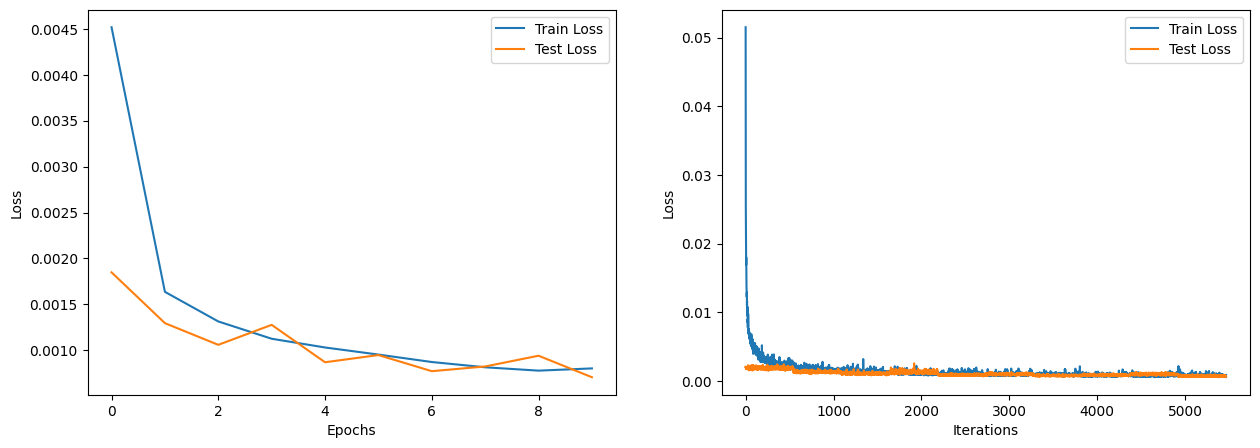

In [18]:
def Plot_Losses(Train_Losses, Test_Losses, Running_Train_Losses, Running_Test_Losses):
    
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(Train_Losses, label='Train Loss')
        plt.plot(Test_Losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
        plt.subplot(1, 2, 2)
        plt.plot(Running_Train_Losses, label='Train Loss')
        plt.plot(Running_Test_Losses, label='Test Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
    
        plt.show()

Plot_Losses(Train_Losses, Test_Losses, Running_Train_Losses[3:], Running_Test_Losses[3:])

The train loss and test loss both decrease as the number of epochs increase. This means that the model is learning the features of the data and is able to generalize well on the test data.

## Saving the model

In [13]:
# Save the model
torch.save(model.state_dict(), 'model.pth')



In [14]:
# Load the model

model = Unet_NN(1, 2).to(device)

model.load_state_dict(torch.load('model.pth'))

model.eval()

Unet_NN(
  (encoder1): DoubleConv2D(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (encoder2): DoubleConv2D(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (encoder3): DoubleConv2D(
    (double_conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

## Evaluating the model

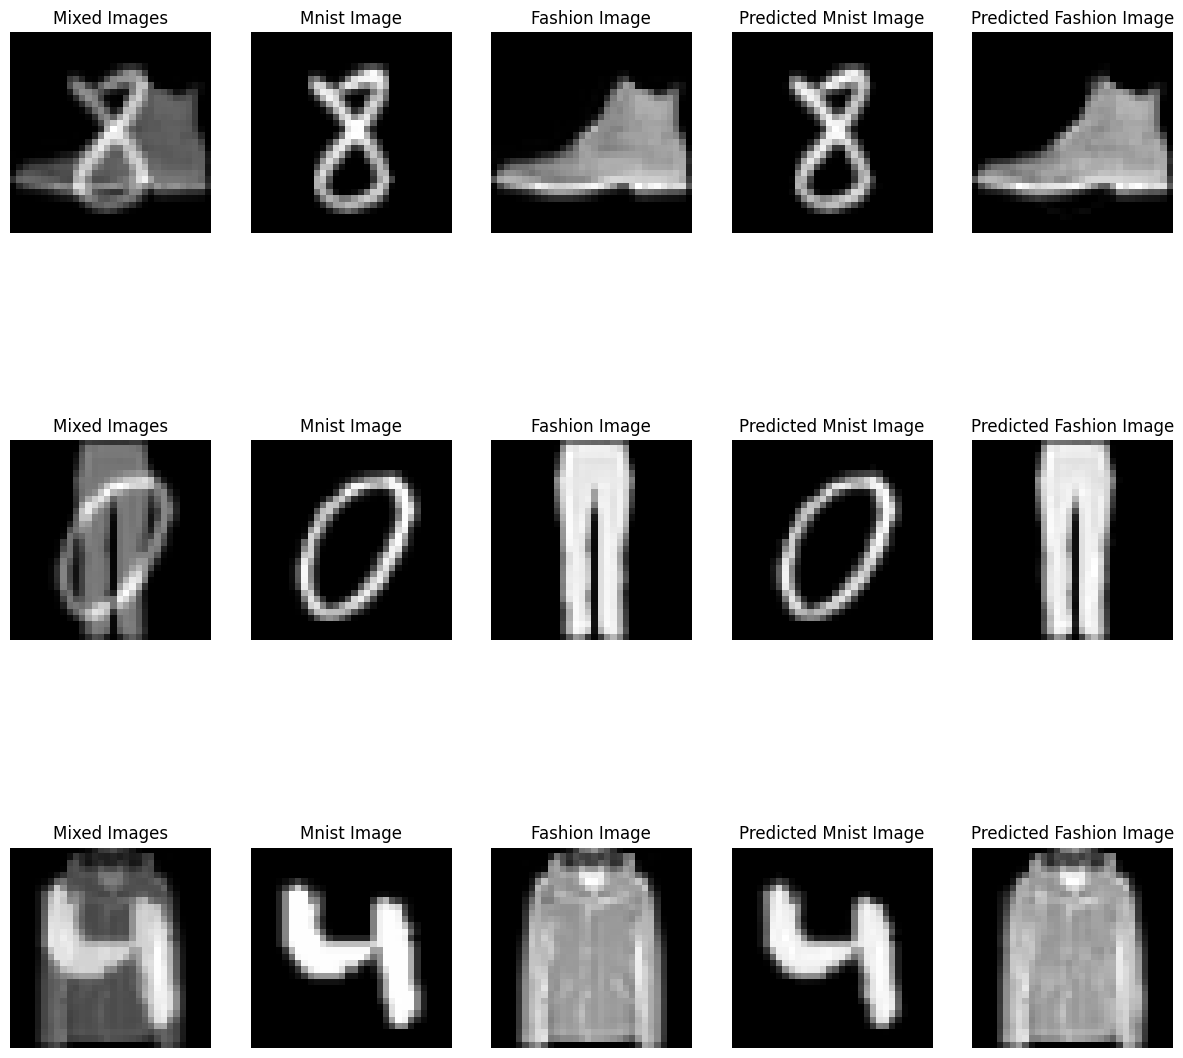

In [20]:
def Show_Predictions(model, test_loader , n = 3):
    model.eval()
    fig, ax = plt.subplots(n, 5, figsize=(15, n*5))

    Idx = np.random.randint(0, len(test_loader), n)

    for i, idx in enumerate(Idx):
        X, Y = test_loader.dataset[idx]
        X = X.unsqueeze(0)
        Y = Y.unsqueeze(0)
        X = X.to(device)
        Y = Y.to(device)
        out = model(X)
        out = out.cpu().detach().numpy()
        out = out.squeeze()
        ax[i, 0].imshow(X.squeeze().cpu().detach().numpy(), cmap='gray')
        ax[i, 0].set_title('Mixed Images')
        ax[i, 0].axis('off')

        for j in range(2):
            ax[i, j+1].imshow(Y[0,j].squeeze().cpu().detach().numpy(), cmap='gray')
            if j == 0:
                ax[i, j+1].set_title('Mnist Image')
            else:
                ax[i, j+1].set_title('Fashion Image')
            ax[i, j+1].axis('off')

        ax[i, 3].imshow(out[0].squeeze(), cmap='gray')
        ax[i, 3].set_title('Predicted Mnist Image')
        ax[i, 3].axis('off')

        ax[i, 4].imshow(out[1].squeeze(), cmap='gray')
        ax[i, 4].set_title('Predicted Fashion Image')
        ax[i, 4].axis('off')

    plt.show()

    

Show_Predictions(model, test_loader)

We notice that the model is able to separate the sources from the mixed images. The model is able to separate the sources with a high accuracy.